For this project I create a voronoi diagram on the map based on data points (or point of interests), voronoi diagram have applications in almost all areas of science and engineering. For geospatial use case, it is useful to tell us the closest point of interest (POI) by representing each POI with a dot inside a polygon shape. So within a polygon, the closest POI is definitely the dot inside the polygon.

Ok, let's start the project. As usual, for the first step let's import all necessary packages

In [1]:
import folium
import numpy as np
import geopandas as gpd
#import contextily as ctx
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import Point, LineString, Polygon

Insert data points/POI into geodaframe

In [2]:
gdf = gpd.GeoDataFrame()
gdf = gdf.append({'geometry': Point(106.644085,-6.305286)}, ignore_index=True)

gdf = gdf.append({'geometry': Point(106.653261,-6.301309)}, ignore_index=True)
gdf = gdf.append({'geometry': Point(106.637751,-6.284774)}, ignore_index=True)
gdf = gdf.append({'geometry': Point(106.665062,-6.284598)}, ignore_index=True)
gdf = gdf.append({'geometry': Point(106.627582,-6.283521)}, ignore_index=True)
gdf = gdf.append({'geometry': Point(106.641365,-6.276593)}, ignore_index=True)
gdf = gdf.append({'geometry': Point(106.625972,-6.303643)}, ignore_index=True)
gdf

,geometry
0,POINT (106.64409 -6.30529)
1,POINT (106.65326 -6.30131)
2,POINT (106.63775 -6.28477)
3,POINT (106.66506 -6.28460)
4,POINT (106.62758 -6.28352)
5,POINT (106.64136 -6.27659)
6,POINT (106.62597 -6.30364)


Determine the coverage area of the voronoi diagram & save it to geodaframe

In [3]:
area_max_lon = 106.670929
area_min_lon = 106.619602
area_max_lat = -6.275713
area_min_lat = -6.309795

lat_point_list = [area_min_lat, area_max_lat,area_max_lat,area_min_lat]
lon_point_list = [area_min_lon, area_min_lon, area_max_lon, area_max_lon]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))

In [4]:
boundary = gpd.GeoDataFrame()
boundary = boundary.append({'geometry': polygon_geom}, ignore_index=True)
boundary

,geometry
0,"POLYGON ((106.61960 -6.30980, 106.61960 -6.275..."


Convert both dataframes to Web Mercator projection

In [5]:
gdf.crs = {'init' :'epsg:3395'}
boundary.crs = {'init' :'epsg:3395'}

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Convert the boundary geometry into a union of the polygon and POI data to NumPy array of coordinates.

In [6]:
boundary_shape = cascaded_union(boundary.geometry)
coords = points_to_coords(gdf.geometry)

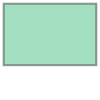

In [7]:
boundary_shape

Calculate voronoi regions

In [8]:
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, boundary_shape)

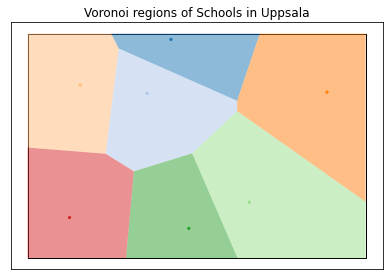

In [9]:
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments)
ax.set_title('Voronoi regions of Schools in Uppsala')
plt.tight_layout()
plt.show()

Visualize the voronoi diagram using folium

In [10]:
m = folium.Map([-6.304029, 106.645874], zoom_start=13, tiles='cartodbpositron')
#draw the voronoi diagram within coverage area
for x in range(len(poly_shapes)):
    folium.GeoJson(poly_shapes[x]).add_to(m)
    
#draw the data points
points = np.array([[-6.305286, 106.644085], [-6.301309, 106.653261], [-6.284774, 106.637751], [-6.284598, 106.665062], [-6.283521, 106.627582],[-6.276593, 106.641365], [-6.303643, 106.625972]])
locs = points
for location in locs:
    folium.CircleMarker(location=location, 
        color = "#4925a2",   radius=0.01).add_to(m)

m